<a href="https://colab.research.google.com/github/girish-srivatsa/itsp/blob/master/google%20colab/Emotify_ITSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all required packages.

import numpy as np
import tensorflow as tf
import keras 
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv1D, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout 
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2

Using TensorFlow backend.


In [ ]:
# Import modules for accessing files in drive.

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Here, I authenticate my google account.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# the url links for the dataset in my drive.

url = "https://drive.google.com/file/d/1tiAwX-8t4XKIVKhN49Vh6H9dVFVQzT5E/view?usp=sharing"
url_id = url[32 : 65]

In [ ]:
# Download the dataset.

downloaded = drive.CreateFile({'id' : url_id})
downloaded.GetContentFile('Final_dataset.csv')

In [ ]:
# Extract the dataset as a dataframe using pandas library.

data = pd.read_csv('Final_dataset.csv')
data.head()

,emotion,pixels,Usage
0,4,243 243 243 243 243 243 243 243 245 243 243 24...,Training
1,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Training
2,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Training
3,4,189 189 189 187 187 187 191 191 191 189 189 18...,Training
4,6,200 196 195 197 197 195 197 197 195 198 197 19...,Training


In [ ]:
# Convert the space seperated pixels into lists.

for i in range(data.shape[0]):
  pix_list = [float(x) for x in data['pixels'][i].split(' ')]
  # pix_list = norm_list(pix_list)
  pix_arr = np.array(pix_list)
  pix_img = np.reshape(pix_arr, (48, 48))
  pix_img_to_list = pix_img.tolist()
  data['pixels'][i] = pix_img_to_list

data.head()

In [ ]:
# Make new dataframes for train, dev and test.

dftrain = data[data['Usage'] == 'Training']
dfdev = data[data['Usage'] == 'PublicTest']
dftest = data[data['Usage'] == 'PrivateTest']
print(dftrain.shape, dfdev.shape, dftest.shape)

dftrain.head()

(30694, 3) (4089, 3) (4122, 3)


,emotion,pixels,Usage
0,0,"[[86.0, 104.0, 151.0, 119.0, 35.0, 26.0, 36.0,...",Training
1,4,"[[30.0, 30.0, 28.0, 30.0, 27.0, 23.0, 11.0, 5....",Training
2,3,"[[226.0, 226.0, 225.0, 223.0, 223.0, 216.0, 21...",Training
3,4,"[[180.0, 133.0, 85.0, 75.0, 63.0, 63.0, 66.0, ...",Training
4,0,"[[14.0, 15.0, 32.0, 72.0, 82.0, 113.0, 180.0, ...",Training


AxesSubplot(0.125,0.125;0.775x0.755)


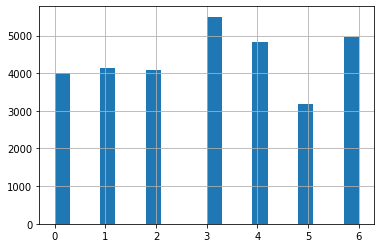

In [ ]:
# Look at the distribution of the emotions in the dataframes.

print(dftrain.emotion.hist(bins = 20))
# print(dfdev.emotion.hist(bins = 20))
# print(dftest.emotion.hist(bins = 20))

In [ ]:
# Count of elements in various dataframes.

train_count = dftrain.shape[0]
dev_count = dfdev.shape[0]
test_count = dftest.shape[0]
img_h = 48
img_w = 48

In [ ]:
# Emotion classes.

y_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [ ]:
# Convert y arrays to one hot matrices.

y_train = np.array(dftrain['emotion'])
y_dev = np.array(dfdev['emotion'])
y_test = np.array(dftest['emotion'])

Y_train = tf.keras.utils.to_categorical(y_train, num_classes = 7)
Y_dev = tf.keras.utils.to_categorical(y_dev, num_classes = 7)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes = 7)

# print(Y_train)

In [ ]:
# Function to extract the numpy array of images from the dataframe.

def get_X(df, start, end):
  x_list = []
  for i in range(start, end):
    x_list.append(df["pixels"][i])
  X = np.array(x_list)
  # X = np.stack([arr] * 3, axis = -1)
  X = X / 255
  return X

In [ ]:
# Extract data using the above get_X() function.

X_train = get_X(dftrain, 0, train_count)
X_dev = get_X(dfdev, train_count, train_count + dev_count)
X_test = get_X(dftest, train_count + dev_count, train_count + dev_count + test_count)

X_train.shape = (train_count, 48, 48, 1)
X_dev.shape = (dev_count, 48, 48, 1)
X_test.shape = (test_count, 48, 48, 1)

X_train.shape

(30694, 48, 48, 1)

In [ ]:
from keras.layers import concatenate

In [ ]:
# Define the model.
dropout_rate = 0.05

def train_model(input_shape):
  X_input = Input(input_shape)
  X = X_input

  X = Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", activation = "relu")(X)
  X = BatchNormalization(axis = 3)(X)
  X = Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu")(X)
  X = BatchNormalization(axis = 3)(X)
  X = MaxPooling2D((2, 2))(X)
  X = Dropout(0.1)(X)
  X = Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu")(X)
  X = BatchNormalization(axis = 3)(X)
  X = Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu")(X)
  X = BatchNormalization(axis = 3)(X)
  X = Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu")(X)
  X = BatchNormalization(axis = 3)(X)
  X = Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu")(X)
  X = BatchNormalization(axis = 3)(X)
  X = MaxPooling2D((2, 2))(X)
  X = Dropout(0.1)(X)
  X = Flatten()(X)
  X = Dense(1024, activation = "relu")(X)
  X = Dropout(0.1)(X)
  X = Dense(7, activation = "softmax")(X)

  model = Model(inputs = X_input, outputs = X)
  return model

In [ ]:
# Initialize the model

Emotion_Model = train_model((48, 48, 1))

In [ ]:
Emotion_Model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0   

In [ ]:
# Compile the model.

Emotion_Model.compile(optimizer = "sgd", loss = "categorical_crossentropy", metrics = ['accuracy'])

In [ ]:
# Fit the model.

Emotion_Model.fit(X_train, Y_train, batch_size = 128, epochs = 5) # = 15

Epoch 1/5
30694/30694 [==============================] - 18s 577us/step - loss: 1.6101 - accuracy: 0.3987
Epoch 2/5
30694/30694 [==============================] - 10s 337us/step - loss: 1.3206 - accuracy: 0.4955
Epoch 3/5
30694/30694 [==============================] - 10s 337us/step - loss: 1.2194 - accuracy: 0.5343
Epoch 4/5
30694/30694 [==============================] - 10s 337us/step - loss: 1.1412 - accuracy: 0.5671
Epoch 5/5
30694/30694 [==============================] - 10s 337us/step - loss: 1.0719 - accuracy: 0.5947


In [ ]:
Emotion_Model.fit(X_train, Y_train, batch_size = 128, epochs = 10)

Epoch 1/10
30694/30694 [==============================] - 10s 338us/step - loss: 1.0188 - accuracy: 0.6218
Epoch 2/10
30694/30694 [==============================] - 10s 342us/step - loss: 0.9638 - accuracy: 0.6420
Epoch 3/10
30694/30694 [==============================] - 10s 339us/step - loss: 0.9154 - accuracy: 0.6608
Epoch 4/10
30694/30694 [==============================] - 10s 337us/step - loss: 0.8705 - accuracy: 0.6808
Epoch 5/10
30694/30694 [==============================] - 10s 337us/step - loss: 0.8192 - accuracy: 0.7035
Epoch 6/10
30694/30694 [==============================] - 10s 337us/step - loss: 0.7750 - accuracy: 0.7195
Epoch 7/10
30694/30694 [==============================] - 10s 336us/step - loss: 0.7187 - accuracy: 0.7418
Epoch 8/10
30694/30694 [==============================] - 10s 336us/step - loss: 0.6773 - accuracy: 0.7551
Epoch 9/10
30694/30694 [==============================] - 10s 337us/step - loss: 0.6246 - accuracy: 0.7786
Epoch 10/10
30694/30694 [============

In [ ]:
Emotion_Model.fit(X_train, Y_train, batch_size = 128, epochs = 10)

Epoch 1/10
30694/30694 [==============================] - 10s 338us/step - loss: 0.5400 - accuracy: 0.8134
Epoch 2/10
30694/30694 [==============================] - 10s 337us/step - loss: 0.4955 - accuracy: 0.8273
Epoch 3/10
30694/30694 [==============================] - 10s 337us/step - loss: 0.4536 - accuracy: 0.8450
Epoch 4/10
30694/30694 [==============================] - 10s 337us/step - loss: 0.4121 - accuracy: 0.8603
Epoch 5/10
30694/30694 [==============================] - 10s 336us/step - loss: 0.3800 - accuracy: 0.8716
Epoch 6/10
30694/30694 [==============================] - 10s 337us/step - loss: 0.3408 - accuracy: 0.8887
Epoch 7/10
30694/30694 [==============================] - 10s 338us/step - loss: 0.3098 - accuracy: 0.9000
Epoch 8/10
30694/30694 [==============================] - 10s 339us/step - loss: 0.2837 - accuracy: 0.9104
Epoch 9/10
30694/30694 [==============================] - 10s 338us/step - loss: 0.2608 - accuracy: 0.9170
Epoch 10/10
30694/30694 [============

In [ ]:
Emotion_Model.fit(X_train, Y_train, batch_size = 128, epochs = 5)

Epoch 1/5
30694/30694 [==============================] - 10s 338us/step - loss: 0.2101 - accuracy: 0.9365
Epoch 2/5
30694/30694 [==============================] - 10s 338us/step - loss: 0.1919 - accuracy: 0.9426
Epoch 3/5
30694/30694 [==============================] - 10s 338us/step - loss: 0.1761 - accuracy: 0.9467
Epoch 4/5
30694/30694 [==============================] - 10s 340us/step - loss: 0.1634 - accuracy: 0.9522
Epoch 5/5
30694/30694 [==============================] - 10s 340us/step - loss: 0.1489 - accuracy: 0.9574


In [ ]:
Emotion_Model.fit(X_train, Y_train, batch_size = 128, epochs = 5)

Epoch 1/5
30694/30694 [==============================] - 10s 338us/step - loss: 0.1340 - accuracy: 0.9618
Epoch 2/5
30694/30694 [==============================] - 10s 337us/step - loss: 0.1252 - accuracy: 0.9647
Epoch 3/5
30694/30694 [==============================] - 10s 338us/step - loss: 0.1165 - accuracy: 0.9685
Epoch 4/5
30694/30694 [==============================] - 10s 337us/step - loss: 0.1100 - accuracy: 0.9696
Epoch 5/5
30694/30694 [==============================] - 10s 338us/step - loss: 0.0989 - accuracy: 0.9732


In [ ]:
Emotion_Model.fit(X_train, Y_train, batch_size = 128, epochs = 5)

Epoch 1/5
30694/30694 [==============================] - 10s 342us/step - loss: 0.0977 - accuracy: 0.9741
Epoch 2/5
30694/30694 [==============================] - 10s 341us/step - loss: 0.0906 - accuracy: 0.9754
Epoch 3/5
30694/30694 [==============================] - 10s 340us/step - loss: 0.0876 - accuracy: 0.9760
Epoch 4/5
30694/30694 [==============================] - 10s 339us/step - loss: 0.0793 - accuracy: 0.9796
Epoch 5/5
30694/30694 [==============================] - 10s 338us/step - loss: 0.0709 - accuracy: 0.9828


In [ ]:
Emotion_Model.fit(X_train, Y_train, batch_size = 128, epochs = 5)

Epoch 1/5
30694/30694 [==============================] - 10s 337us/step - loss: 0.0722 - accuracy: 0.9813
Epoch 2/5
30694/30694 [==============================] - 10s 337us/step - loss: 0.0688 - accuracy: 0.9829
Epoch 3/5
30694/30694 [==============================] - 10s 338us/step - loss: 0.0645 - accuracy: 0.9838
Epoch 4/5
30694/30694 [==============================] - 10s 339us/step - loss: 0.0609 - accuracy: 0.9848
Epoch 5/5
30694/30694 [==============================] - 10s 340us/step - loss: 0.0592 - accuracy: 0.9847


In [ ]:
# Evaluate model on the dev set.

Emotion_Model.evaluate(X_dev, Y_dev, batch_size = 64, verbose = 1) 

4089/4089 [==============================] - 1s 149us/step


[1.5797972715288715, 0.629493772983551]

In [ ]:
# Evaluate model on the test set.

Emotion_Model.evaluate(X_test, Y_test, batch_size = 64, verbose = 1)

4122/4122 [==============================] - 1s 144us/step


[1.5091670078886532, 0.634158194065094]

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
model_name = "emotions-(1).h5"
path = F'/content/drive/My Drive/Model_folder/{model_name}' 
Emotion_Model.save(model_name, path)

In [ ]:
import dlib
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt


def detect_faces(image):

    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Run detector and get bounding boxes of the faces on image.
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

In [ ]:
import cv2

def facecrop(image):
    facedata = r"C:\Users\Prajeeth\miniconda3\envs\tensorflow\Lib\site-packages\cv2\data\haarcascade_frontalface_alt.xml"
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image, 0)

    minisize = (img.shape[1],img.shape[0])
    miniframe = cv2.resize(img, minisize)

    faces = cascade.detectMultiScale(miniframe)

    for f in faces:
        x, y, w, h = [ v for v in f ]
        cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,255))

        sub_face = img[y:y+h, x:x+w]
        fname, ext = os.path.splitext(image)
        new_path = fname + "_cropped_" + ext
        cv2.imwrite(new_path, sub_face)

    return new_path

In [ ]:
image_url = "https://drive.google.com/file/d/1WMadxACCP5O_kHL2hd9pxqaXHG91Im4g/view?usp=sharing"
image_id = image_url[32:65]
image_id

'1WMadxACCP5O_kHL2hd9pxqaXHG91Im4g'

In [ ]:
downloaded = drive.CreateFile({'id' : image_id})
downloaded.GetContentFile('image_4.jpeg')

In [ ]:
# Load image
img_path = 'image_4.jpeg'
image = io.imread(img_path)
image

array([[[236, 237, 232],
        [236, 237, 232],
        [236, 237, 232],
        ...,
        [164, 136, 115],
        [215, 184, 164],
        [210, 179, 158]],

       [[236, 237, 232],
        [236, 237, 232],
        [236, 237, 232],
        ...,
        [213, 185, 164],
        [229, 198, 178],
        [216, 185, 164]],

       [[236, 237, 232],
        [236, 237, 232],
        [236, 237, 232],
        ...,
        [228, 200, 179],
        [232, 201, 181],
        [233, 202, 182]],

       ...,

       [[ 52,  55,  62],
        [ 62,  65,  72],
        [ 59,  62,  69],
        ...,
        [ 14,  17,  22],
        [ 33,  36,  41],
        [ 12,  15,  20]],

       [[ 57,  60,  67],
        [ 57,  60,  67],
        [ 37,  40,  47],
        ...,
        [ 12,  15,  20],
        [ 31,  34,  39],
        [ 20,  23,  28]],

       [[ 79,  82,  89],
        [ 45,  48,  55],
        [ 13,  16,  23],
        ...,
        [  8,  13,  19],
        [ 29,  32,  39],
        [ 28,  31,  38]]

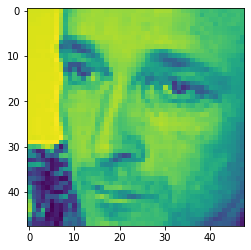

In [ ]:
# Detect faces
detected_faces = detect_faces(image)

# Crop faces and plot
for n, face_rect in enumerate(detected_faces):
    face = Image.fromarray(image).crop(face_rect)
    face.thumbnail((48, 48), Image.ANTIALIAS)
    face = face.convert('L')
    face.save(img_path)
    plt.imshow(face)

In [ ]:
import numpy as np
face_arr = np.asarray(face, dtype = np.float32)
face_arr = face_arr / 255
# face_arr
face_arr.shape = (1, 48, 48, 1)

# face.save(image_path)

In [ ]:
pred_arr = Emodel.predict(face_arr, verbose = 1)
pred_arr

1/1 [==============================] - 6s 6s/step


array([[0.1619563 , 0.0019418 , 0.1443102 , 0.00653373, 0.12347215,
        0.05256133, 0.5092245 ]], dtype=float32)

In [ ]:
print(np.argmax(pred_arr))

print(y_classes[np.argmax(pred_arr)])

6
Neutral
